In [183]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.metrics import mean_squared_error
generate_loss_plots = True # if we want to build loss plots for components 1:16

In [184]:
# Read in data
train = np.load('./MNIST_training_set.npy', allow_pickle=True).item() # Get items
test = np.load('./MNIST_test_set.npy', allow_pickle=True).item() # Get items
X_train, y_train = train['features'], train['labels'] # Split data
X_test, y_test = test['features'], test['labels'] # Split data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) # Print Shape of data

(2000, 256) (2000,) (500, 256) (500,)


In [185]:
# Create PCA Model for all components
pca = PCA() # Initialize
pca.fit(X_train); # Fit on training data

In [186]:
'''
Function to reduce dimensionality of data. Takes in PCA, data,
and number of principal components to keep
'''
def dataModeApproximation(pca_model, X_data, N_comp):
    # Reduce data and generate approximation
    all_components = np.copy(pca_model.components_) # Get all components
    X_pca = pca_model.transform(X_data) # Transform Data
    X_reduced = np.dot(X_data - pca_model.mean_, 
                       pca_model.components_[:N_comp].T) # Reduce Data
    pca_model.components_[N_comp:] = 0 # Zero out non-desired components
    X_approx = pca_model.inverse_transform(X_pca) # Inverse transform
    pca_model.components_ = all_components # Reset components
    
    # Return
    return X_reduced, X_approx # Return data

In [187]:
# Calculate Reduced dataset and approximation
N = 16 # Components to keep
X_train_red, X_train_red_approx = dataModeApproximation(pca, X_train, N) # 16 mode approx
_, X_train_32_approx = dataModeApproximation(pca, X_train, 2*N) # 32 mode approx
_, X_train_64_approx = dataModeApproximation(pca, X_train, 4*N) # 64 mode approx
X_train_red.shape

(2000, 16)

In [188]:
'''
Helper Function to Plot. Takes in list of data to plot in gridspace, number of digits to plot,
and list titles to use for each grid
'''
def plotModeApproximations(X_list, N_digits, titles):
    if not isinstance(X_list, list): # Convert to list if needed
        X_list = list(X_list)
    if not isinstance(titles, list): 
        titles = list(titles)
        
    # Parameters based on number of plots
    L = len(X_list) # Number of plots
    N = int(np.sqrt(N_digits)) # Length of squares
    grid_x = int(max(1, N // 4)) # Width, max at 4 plots
    grid_y = int(L if L <= 4 else 4) # Height
    p_width = N * grid_y # Plot width
    p_height = N * grid_x # Plot height
    
    # Generate Plot
    fig = plt.figure(figsize=(p_width, p_height))
    gs0 = gs.GridSpec(grid_x, grid_y)
    for idx, X in enumerate(X_list): # Iterate over data included
        gsx = gs.GridSpecFromSubplotSpec(N, N, subplot_spec = gs0[idx])
        for i in range(N): # Iterate through digits
            for j in range(N): # Iterate through digits
                ax = fig.add_subplot(gsx[i, j])
                ax.imshow(X[(N)*i+j,:].reshape((16, 16)), cmap="Greys")
                ax.axis("off")
        # Dummy axis to add titles
        ax = fig.add_subplot(gsx[:])
        ax.axis('off')
        ax.set_title(titles[idx])

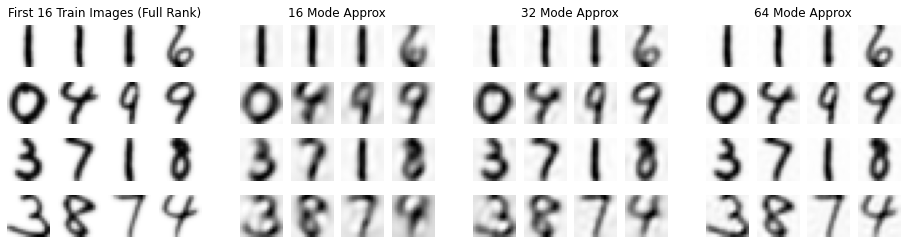

In [189]:
# Plot comparison of full rank first 16 images vs. 16 component approx vs. 32 comp
plotModeApproximations([X_train, X_train_red_approx, X_train_32_approx, X_train_64_approx], 16, 
                        ['First 16 Train Images (Full Rank)', '16 Mode Approx','32 Mode Approx', '64 Mode Approx'])

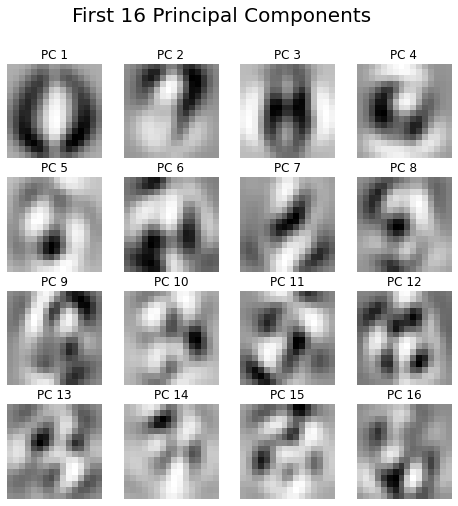

In [190]:
# Plot first 16 PCA Modes
first_modes = pca.components_ # Extract the first modes
fig, ax = plt.subplots(4, 4, figsize=(8,8)) # Four x four space
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(first_modes[(4 * i) + j, :].reshape((16, 16)), cmap="Greys") # Plot component
        ax[i, j].axis('off')
        ax[i, j].set_title('PC ' + str((4 * i) + j + 1)) # Set title
fig.suptitle('First 16 Principal Components', fontsize=20)
plt.show()

In [191]:
# Get number of modes for specified variances
ratio_sums = np.cumsum(pca.explained_variance_ratio_)
num_comps = lambda pct: np.where(ratio_sums >= pct)[0].min() + 1 # Helper lambda function
var_60 = num_comps(0.60) # 60% Variance
var_80 = num_comps(0.80) # 80% Variance
var_90 = num_comps(0.90) # 90% Variance
var_95 = num_comps(0.95) # 95% Variance
var_99 = num_comps(0.99) # 99% Variance
print(var_60, var_80, var_90, var_95, var_99) # Print Results

6 13 23 34 65


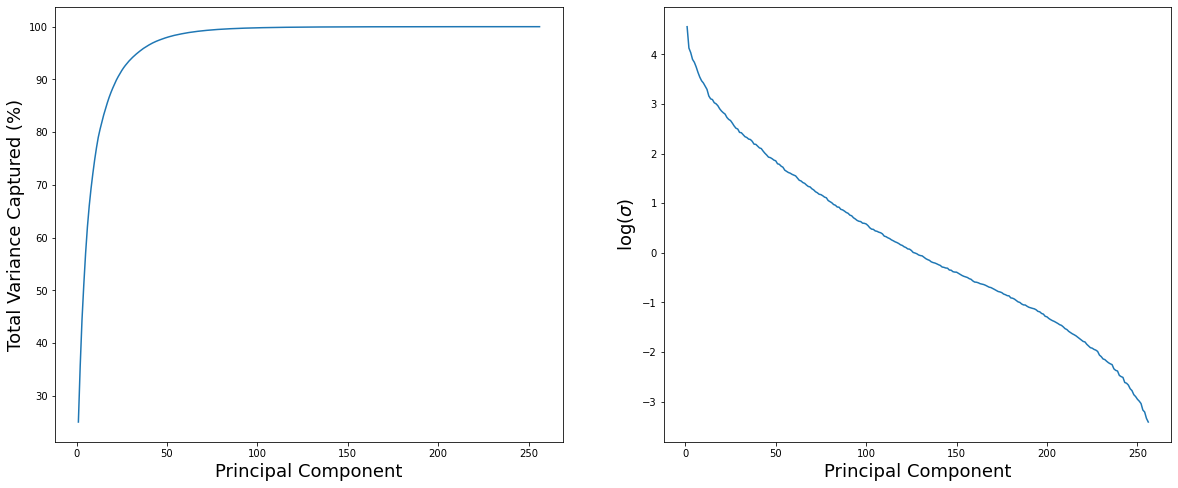

In [192]:
# Generate some variance plots
x_dat = np.arange(1, ratio_sums.shape[0] + 1) # x axis values
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(x_dat, 100 * ratio_sums)
ax[0].set_xlabel('Principal Component', fontsize=18)
ax[0].set_ylabel('Total Variance Captured (%)', fontsize=18)
ax[1].plot(x_dat, np.log(pca.singular_values_))
ax[1].set_xlabel('Principal Component', fontsize=18)
ax[1].set_ylabel('log($\sigma$)', fontsize=18)
plt.show()

In [193]:
'''
Function that extracts specified digits from MNIST dataset and creates
a dimensionally reduced dataset using only two specified digits. Takes in data, labels,
number of PCA components to use, and the digits to use. Uses 1, 2 if no digits are
specified.
'''
def reducedBinaryDigitSet(pca_model, N_comp, X_data, y_data, digits=None):
    if digits is None: # Use all digits if not specified
        digits = [1,2]
        print('No Digits Specified - Assuming 1, 2')
    
    # Update data
    idxs_to_use = np.where(np.isin(y_data, digits))[0] # Find rows of matching entries
    y_labs_new = y_data[idxs_to_use] # Get labels
    X_data_new = X_data[idxs_to_use, :] # Get Data
    y_labs_new = np.where(y_labs_new == digits[0], -1, 1) # Normalize classifier
    
    # Reduce new X_data using previous function
    X_data_new_red, _ = dataModeApproximation(pca_model, X_data_new, N_comp) 
    
    # Return data
    return X_data_new_red, y_labs_new

In [194]:
'''
Function to generate RidgeRegression Model. Takes in tuple of train data/labels,
tuple of test data/labels, and parameters needed to execute reducedBinaryDataset and
dataModeApproximation. Returns model, mean square error and percent prediction for train and 
test. Regression value of < 0 is a prediction of the negative value, > 0 is a 
prediction of the positive value. Optionally can specify a random state to control results
'''
def ridgeClassifierForDigits(train_dat, test_dat, pca_model, N_comp, digits=None, 
                             alphas=np.linspace(0.05, 20, 1000), random_state=None):
    # Separate/Reduce Data
    X_train, y_train = train_dat[0], train_dat[1]
    X_test, y_test = test_dat[0], test_dat[1]
    X_train_red, y_train_red = reducedBinaryDigitSet(pca_model, N_comp, X_train, 
                                                     y_train, digits=digits)
    X_test_red, y_test_red = reducedBinaryDigitSet(pca_model, N_comp, X_test, 
                                                   y_test, digits=digits)
    
    # Create Ridge Regression Model for selecting alpha
    ridge_alpha = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error') # use MSE for scoring
    ridge_alpha.fit(X_train_red, y_train_red) # Fit on training data
    alpha_best = ridge_alpha.alpha_ # Select best alpha value
    
    # Create ridge model using best alpha, predict on data
    ridge_model = Ridge(alpha=alpha_best, random_state=random_state)
    ridge_model.fit(X_train_red, y_train_red) # Fit on training data
    y_train_pred = ridge_model.predict(X_train_red) # Predict on train data
    y_test_pred = ridge_model.predict(X_test_red) # Predict on test_data
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train_pred, y_train_red) # train MSE
    test_mse = mean_squared_error(y_test_pred, y_test_red) # test MSE
    y_train_pred_binary = np.where(y_train_pred <= 0, -1, 1) # Convert to classes
    y_test_pred_binary = np.where(y_test_pred <= 0, -1, 1) # Convert to absolutes
    train_correct = np.count_nonzero(y_train_pred_binary == y_train_red) / len(y_train_pred) # % correct train
    test_correct = np.count_nonzero(y_test_pred_binary == y_test_red) / len(y_test_pred) # % correct test
        
    return (train_mse, train_correct, test_mse, test_correct), ridge_model
    

In [195]:
# Run models
N = 16 # Components to use
train = (X_train, y_train)
test = (X_test, y_test)
res18, m18 = ridgeClassifierForDigits(train, test, pca, N, digits=[1,8]) # digits [1,8]
res38, m38 = ridgeClassifierForDigits(train, test, pca, N, digits=[3,8]) # digits [3,8]
res27, m27 = ridgeClassifierForDigits(train, test, pca, N, digits=[2,7]) # digits [2,7]

In [ ]:
# Run for different N values and record error
if generate_loss_plots:
    components = np.arange(1, 24+1)
    train_mse = {'[1,8]':[], '[3,8]': [], '[2,7]':[]} # Training MSE
    testing_mse = {'[1,8]':[], '[3,8]': [], '[2,7]':[]} # Test MSE
    for c in components:
        res18, _ = ridgeClassifierForDigits(train, test, pca, c, digits=[1,8]) # digits [1,8]
        res38, _ = ridgeClassifierForDigits(train, test, pca, c, digits=[3,8]) # digits [3,8]
        res27, _ = ridgeClassifierForDigits(train, test, pca, c, digits=[2,7]) # digits [2,7]
        train_mse['[1,8]'].append(res18[0]), testing_mse['[1,8]'].append(res18[2])
        train_mse['[3,8]'].append(res38[0]), testing_mse['[3,8]'].append(res38[2])
        train_mse['[2,7]'].append(res27[0]), testing_mse['[2,7]'].append(res27[2])
        
    # Plot the results
    # Train
    fig, ax = plt.subplots(1, 2, figsize=(20,8))
    for k, train_v in train_mse.items():
        ax[0].plot(components, train_v, label=k)
    ax[0].set_xlabel('Number of Components')
    ax[0].set_ylabel('MSE')
    ax[0].legend()
    
    # Test
    for k, test_v in test_mse.items():
        ax[1].plot(components, test_v, label=k)
    ax[1].set_xlabel('Number of Components')
    ax[1].set_ylabel('MSE')
    ax[1].legend()